# Notebook 05: Cross-Validation & Leakage

## The Validation Trap

Data leakage is the silent killer of model insights. When training and test sets share information they shouldn't, metrics become misleading. GroupKFold and TimeSeriesSplit prevent this, ensuring our interpretations reflect reality.

---

## What is Data Leakage?

Data leakage occurs when information from the future or from other groups leaks into training data:

- **Temporal leakage**: Using future data to predict the past
- **Group leakage**: Same entity appears in both train and test
- **Target leakage**: Using information that wouldn't be available at prediction time

## Cross-Validation Schemes

- **KFold**: Standard k-fold CV (assumes independent samples)
- **GroupKFold**: Ensures groups don't split across folds
- **TimeSeriesSplit**: Respects temporal order

## When to Use Each

- **KFold**: Independent samples, no groups, no time order
- **GroupKFold**: Repeated measurements, player/patient IDs
- **TimeSeriesSplit**: Time series, temporal data

## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import sys
from pathlib import Path
project_root = Path().resolve().parent if Path().resolve().name == 'notebooks' else Path().resolve()
sys.path.insert(0, str(project_root))

from src.utils import set_seed

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

set_seed(42)
print("✓ Imports successful!")

✓ Imports successful!


### Understanding KFold vs GroupKFold

**The Problem: Group Leakage**

Imagine you have data from multiple patients, where each patient has multiple measurements:
- Patient A: measurements [1, 2, 3]
- Patient B: measurements [4, 5]
- Patient C: measurements [6, 7]
- Patient D: measurement [8]

**What KFold Does (WRONG for grouped data):**
- KFold randomly splits by **row indices**, not by groups
- **Problem**: It might put Patient A's measurement #1 in training and measurement #2 in test
- This is **data leakage** because the model learns patterns from Patient A, then predicts on Patient A again
- The model "cheats" by seeing the same patient in both train and test
- **Result**: Overly optimistic scores (model performs better than it should)

**What GroupKFold Does (CORRECT for grouped data):**
- GroupKFold splits by **groups**, keeping all measurements from the same group together
- **Solution**: If Patient A is in training, ALL of Patient A's measurements are in training
- If Patient A is in test, ALL of Patient A's measurements are in test
- The model never sees the same patient in both train and test
- **Result**: More conservative (realistic) scores

**Why This Matters:**
- In real scenarios, you want to predict on **new patients**, not the same patients you trained on
- GroupKFold simulates this by ensuring groups don't leak between folds
- This gives you a better estimate of how your model will perform on truly unseen data


## Step 1: KFold vs GroupKFold

Demonstrate how GroupKFold prevents group leakage.

In [4]:
# === TODO: Demonstrate KFold vs GroupKFold
# Hints:
#   - Create toy dataset with repeated group IDs
#   - Apply KFold and GroupKFold
#   - Show that GroupKFold keeps groups together
#   - Compare CV scores
# Acceptance: Show GroupKFold gives more conservative estimate

# Create toy dataset with groups
# Each group has multiple measurements (like multiple measurements per patient)
toy_data = pd.DataFrame({
    'group': ['A', 'A', 'A', 'B', 'B', 'C', 'C', 'D'],
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8],
    'feature2': [10, 11, 12, 13, 14, 15, 16, 17],
    'target': [100, 101, 102, 103, 104, 105, 106, 107]
})

print("=" * 80)
print("Toy Dataset:")
print("=" * 80)
print(toy_data)
print("\n")

# Prepare features and target
X = toy_data[['feature1', 'feature2']]
y = toy_data['target']
groups = toy_data['group']

# Create CV objects
k_fold = KFold(n_splits=2, shuffle=True, random_state=42)
group_k_fold = GroupKFold(n_splits=2)

print("=" * 80)
print("KFold Splits (CAN split groups across train/test - DATA LEAKAGE!):")
print("=" * 80)
for fold_num, (train_idx, test_idx) in enumerate(k_fold.split(X), 1):
    train_groups = groups.iloc[train_idx].unique()
    test_groups = groups.iloc[test_idx].unique()
    overlap = set(train_groups) & set(test_groups)
    
    print(f"\nFold {fold_num}:")
    print(f"  Train indices: {train_idx}")
    print(f"  Test indices: {test_idx}")
    print(f"  Train groups: {sorted(train_groups)}")
    print(f"  Test groups: {sorted(test_groups)}")
    if overlap:
        print(f"  ⚠️  WARNING: Groups {sorted(overlap)} appear in BOTH train and test (LEAKAGE!)")
    else:
        print(f"  ✓ No group overlap")

print("\n" + "=" * 80)
print("GroupKFold Splits (KEEPS groups together - NO LEAKAGE):")
print("=" * 80)
for fold_num, (train_idx, test_idx) in enumerate(group_k_fold.split(X, y, groups=groups), 1):
    train_groups = groups.iloc[train_idx].unique()
    test_groups = groups.iloc[test_idx].unique()
    overlap = set(train_groups) & set(test_groups)
    
    print(f"\nFold {fold_num}:")
    print(f"  Train indices: {train_idx}")
    print(f"  Test indices: {test_idx}")
    print(f"  Train groups: {sorted(train_groups)}")
    print(f"  Test groups: {sorted(test_groups)}")
    if overlap:
        print(f"  ⚠️  WARNING: Groups {sorted(overlap)} appear in BOTH train and test")
    else:
        print(f"  ✓ No group overlap (all groups kept together)")

# Compare CV scores
print("\n" + "=" * 80)
print("Cross-Validation Scores Comparison:")
print("=" * 80)

model = Ridge(alpha=1.0)

# KFold CV (with potential leakage)
k_fold_scores = cross_val_score(
    model, X, y, 
    cv=k_fold, 
    scoring='r2',
    n_jobs=-1
)

# GroupKFold CV (no leakage)
group_k_fold_scores = cross_val_score(
    model, X, y, 
    cv=group_k_fold, 
    groups=groups,
    scoring='r2',
    n_jobs=-1
)

print(f"\nKFold scores: {k_fold_scores}")
print(f"KFold mean: {k_fold_scores.mean():.4f} ± {k_fold_scores.std():.4f}")

print(f"\nGroupKFold scores: {group_k_fold_scores}")
print(f"GroupKFold mean: {group_k_fold_scores.mean():.4f} ± {group_k_fold_scores.std():.4f}")

print(f"\n{'='*80}")
print("Key Insight:")
print(f"{'='*80}")
print("GroupKFold typically gives LOWER (more conservative) scores because:")
print("1. It prevents data leakage (same group in train and test)")
print("2. It better simulates real-world scenario (predicting on new groups)")
print("3. KFold scores are often inflated due to leakage")
print(f"\nDifference: {k_fold_scores.mean() - group_k_fold_scores.mean():.4f} "
      f"(KFold is {k_fold_scores.mean() - group_k_fold_scores.mean():.4f} points higher - likely due to leakage)")



Toy Dataset:
  group  feature1  feature2  target
0     A         1        10     100
1     A         2        11     101
2     A         3        12     102
3     B         4        13     103
4     B         5        14     104
5     C         6        15     105
6     C         7        16     106
7     D         8        17     107


KFold Splits (CAN split groups across train/test - DATA LEAKAGE!):

Fold 1:
  Train indices: [2 3 4 6]
  Test indices: [0 1 5 7]
  Train groups: ['A', 'B', 'C']
  Test groups: ['A', 'C', 'D']
  ⚠️  WARNING: Groups ['A', 'C'] appear in BOTH train and test (LEAKAGE!)

Fold 2:
  Train indices: [0 1 5 7]
  Test indices: [2 3 4 6]
  Train groups: ['A', 'C', 'D']
  Test groups: ['A', 'B', 'C']
  ⚠️  WARNING: Groups ['A', 'C'] appear in BOTH train and test (LEAKAGE!)

GroupKFold Splits (KEEPS groups together - NO LEAKAGE):

Fold 1:
  Train indices: [3 4 5 6]
  Test indices: [0 1 2 7]
  Train groups: ['B', 'C']
  Test groups: ['A', 'D']
  ✓ No group overlap (al

## Step 2: TimeSeriesSplit

Demonstrate temporal cross-validation.

### Understanding TimeSeriesSplit

**The Problem: Temporal Leakage**

In time series data, the order matters! You can't use future data to predict the past.

**Example Scenario:**
- You have daily stock prices from Jan 1 to Dec 31
- You want to predict tomorrow's price using today's price
- **WRONG**: Use Dec 31 data to predict Jan 1 (using future to predict past!)
- **RIGHT**: Use Jan 1 data to predict Jan 2 (using past to predict future)

**What KFold Does (WRONG for time series):**
- KFold randomly shuffles data and splits it
- **Problem**: It might put December data in training and January data in test
- This is **temporal leakage** - using future information to predict the past
- **Result**: Overly optimistic scores (model "sees the future")

**What TimeSeriesSplit Does (CORRECT for time series):**
- TimeSeriesSplit respects temporal order
- **Fold 1**: Train on [Jan 1 - Jan 25], Test on [Jan 26 - Jan 31]
- **Fold 2**: Train on [Jan 1 - Jan 31], Test on [Feb 1 - Feb 28]
- **Fold 3**: Train on [Jan 1 - Feb 28], Test on [Mar 1 - Mar 31]
- Each fold uses **only past data** to predict **future data**
- **Result**: Realistic scores that reflect real-world performance

**Key Characteristics:**
1. **Expanding Window**: Training set grows with each fold (includes all previous data)
2. **Future Test**: Test set is always in the future relative to training
3. **No Shuffling**: Data order is preserved
4. **Simulates Real Deployment**: Like predicting tomorrow using today's model

**Visual Pattern:**
```
Fold 1: [Train========] [Test====]
Fold 2: [Train============] [Test====]
Fold 3: [Train================] [Test====]
```

Each fold trains on more historical data and tests on the next time period.


Time Series Dataset (first 10 and last 10 rows):
        date  day_of_year  month      target
0 2020-01-01            1      1  104.967142
1 2020-01-02            2      1   99.627458
2 2020-01-03            3      1  108.497087
3 2020-01-04            4      1  118.260602
4 2020-01-05            5      1  101.698870
5 2020-01-06            6      1  102.709135
6 2020-01-07            7      1  121.852734
7 2020-01-08            8      1  114.745054
8 2020-01-09            9      1  103.386064
9 2020-01-10           10      1  114.516510
...
         date  day_of_year  month      target
90 2020-03-31           91      3  191.879866
91 2020-04-01           92      4  201.605642
92 2020-04-02           93      4  185.908762
93 2020-04-03           94      4  190.662772
94 2020-04-04           95      4  191.028413
95 2020-04-05           96      4  181.324446
96 2020-04-06           97      4  199.930900
97 2020-04-07           98      4  200.590351
98 2020-04-08           99      4  199

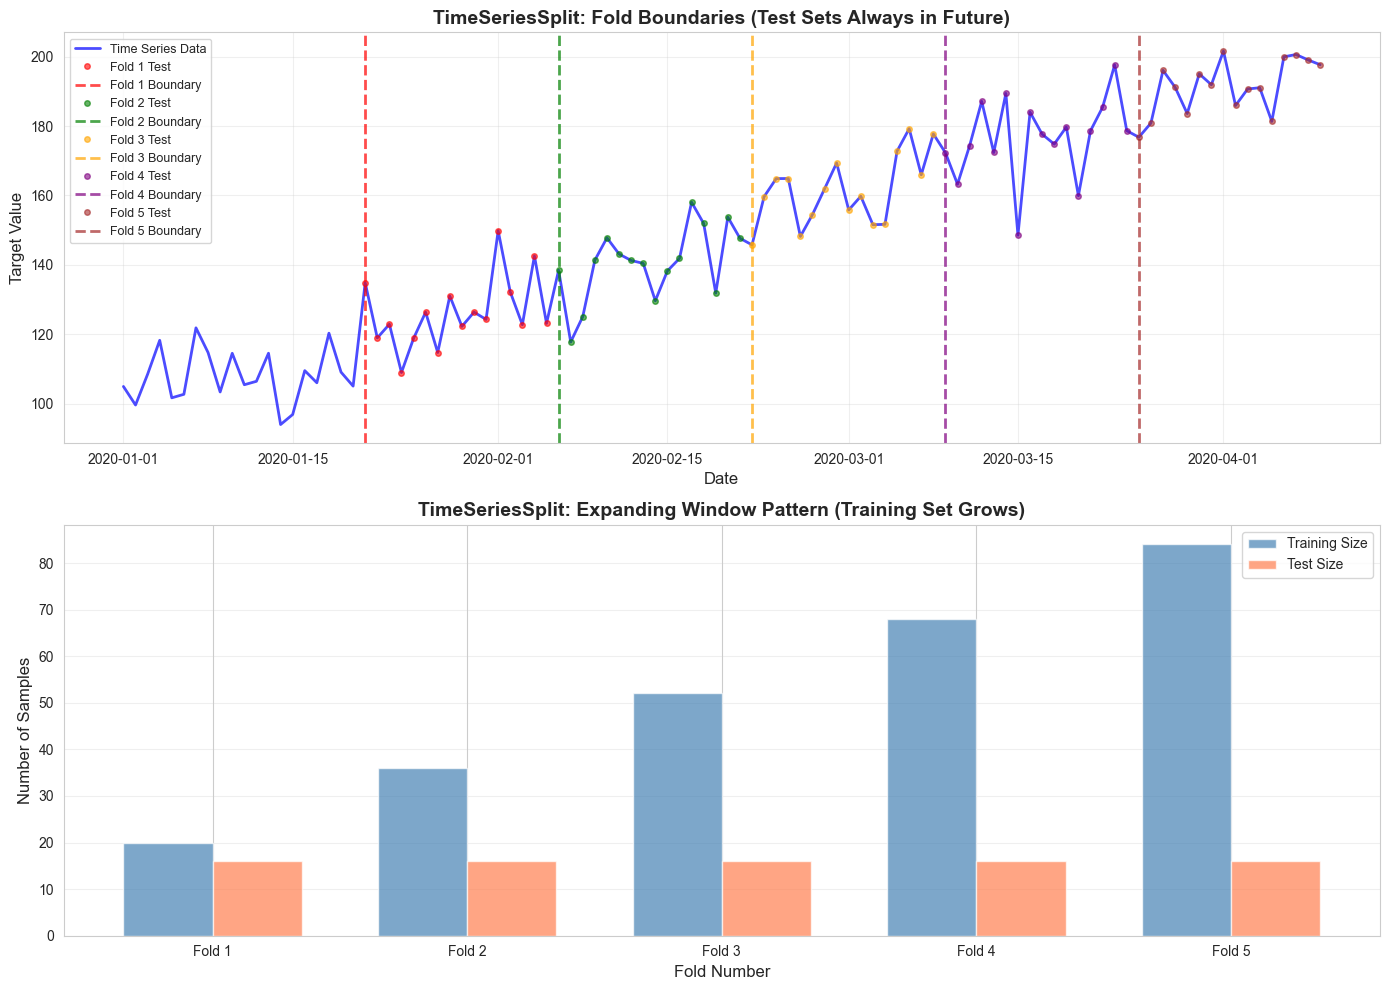


Cross-Validation Metrics for Each Fold:

Fold 1:
  RMSE: 20.5957
  MAE:  18.1117
  R²:   -3.3883

Fold 2:
  RMSE: 8.9450
  MAE:  7.2823
  R²:   0.2393

Fold 3:
  RMSE: 10.7420
  MAE:  8.9788
  R²:   -0.2172

Fold 4:
  RMSE: 11.1000
  MAE:  8.1410
  R²:   0.0846

Fold 5:
  RMSE: 6.7512
  MAE:  5.5989
  R²:   0.2010

Summary Statistics Across All Folds:
Mean RMSE: 11.6268 ± 5.3025
Mean MAE:  9.6225 ± 4.9077
Mean R²:   -0.6161 ± 1.5600

Key Insight:
TimeSeriesSplit ensures:
1. ✓ No temporal leakage (test is always after training)
2. ✓ Expanding window (more historical data in later folds)
3. ✓ Realistic performance estimate (simulates real-world deployment)
4. ✓ Respects time order (no shuffling)


In [6]:
# Complete TimeSeriesSplit implementation
# Create time-ordered dataset with a trend (simulating real time series)
np.random.seed(42)
n_samples = 100
dates = pd.date_range(start='2020-01-01', periods=n_samples, freq='D')

# Create features and target with temporal structure
time_series_data = pd.DataFrame({
    'date': dates,
    'day_of_year': dates.dayofyear,
    'month': dates.month,
    'target': np.linspace(100, 200, n_samples) + np.random.randn(n_samples) * 10
})

# Features (using day_of_year and month as predictors)
X = time_series_data[['day_of_year', 'month']]
y = time_series_data['target']

print("=" * 80)
print("Time Series Dataset (first 10 and last 10 rows):")
print("=" * 80)
print(time_series_data.head(10))
print("...")
print(time_series_data.tail(10))
print("\n")

# Create TimeSeriesSplit with 5 folds
time_series_split = TimeSeriesSplit(n_splits=5)

print("=" * 80)
print("TimeSeriesSplit Folds (Expanding Window Pattern):")
print("=" * 80)

fold_info = []
for fold_num, (train_idx, test_idx) in enumerate(time_series_split.split(X, y), 1):
    train_start = time_series_data['date'].iloc[train_idx[0]]
    train_end = time_series_data['date'].iloc[train_idx[-1]]
    test_start = time_series_data['date'].iloc[test_idx[0]]
    test_end = time_series_data['date'].iloc[test_idx[-1]]
    
    print(f"\nFold {fold_num}:")
    print(f"  Train: {len(train_idx)} samples [{train_start.date()} to {train_end.date()}]")
    print(f"  Test:  {len(test_idx)} samples [{test_start.date()} to {test_end.date()}]")
    print(f"  ✓ Test is AFTER training (no temporal leakage)")
    
    fold_info.append({
        'fold': fold_num,
        'train_size': len(train_idx),
        'test_size': len(test_idx),
        'train_start': train_start,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': test_end,
        'train_idx': train_idx,
        'test_idx': test_idx
    })

# Visualize fold boundaries
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Time series with fold boundaries
ax1.plot(time_series_data['date'], y, 'b-', linewidth=2, label='Time Series Data', alpha=0.7)
colors = ['red', 'green', 'orange', 'purple', 'brown']

for i, info in enumerate(fold_info):
    # Highlight test regions
    test_dates = time_series_data['date'].iloc[info['test_idx']]
    test_values = y.iloc[info['test_idx']]
    ax1.plot(test_dates, test_values, 'o', color=colors[i], markersize=4, 
             label=f"Fold {info['fold']} Test", alpha=0.6)
    
    # Draw boundary line
    ax1.axvline(x=info['test_start'], color=colors[i], linestyle='--', 
                linewidth=2, alpha=0.7, label=f"Fold {info['fold']} Boundary")

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Target Value', fontsize=12)
ax1.set_title('TimeSeriesSplit: Fold Boundaries (Test Sets Always in Future)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Training set size growth (expanding window)
fold_numbers = [info['fold'] for info in fold_info]
train_sizes = [info['train_size'] for info in fold_info]
test_sizes = [info['test_size'] for info in fold_info]

x_pos = np.arange(len(fold_numbers))
width = 0.35

ax2.bar(x_pos - width/2, train_sizes, width, label='Training Size', color='steelblue', alpha=0.7)
ax2.bar(x_pos + width/2, test_sizes, width, label='Test Size', color='coral', alpha=0.7)

ax2.set_xlabel('Fold Number', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_title('TimeSeriesSplit: Expanding Window Pattern (Training Set Grows)', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Fold {f}' for f in fold_numbers])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../images/05_timeseries_split.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute fold metrics
print("\n" + "=" * 80)
print("Cross-Validation Metrics for Each Fold:")
print("=" * 80)

model = Ridge(alpha=1.0)
fold_metrics = []

for fold_num, (train_idx, test_idx) in enumerate(time_series_split.split(X, y), 1):
    # Train on this fold's training set
    X_train_fold = X.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_test_fold = X.iloc[test_idx]
    y_test_fold = y.iloc[test_idx]
    
    # Fit and predict
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold)
    
    # Compute metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred))
    mae = mean_absolute_error(y_test_fold, y_pred)
    r2 = r2_score(y_test_fold, y_pred)
    
    fold_metrics.append({
        'fold': fold_num,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'train_size': len(train_idx),
        'test_size': len(test_idx)
    })
    
    print(f"\nFold {fold_num}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")

# Summary statistics
metrics_df = pd.DataFrame(fold_metrics)
print("\n" + "=" * 80)
print("Summary Statistics Across All Folds:")
print("=" * 80)
print(f"Mean RMSE: {metrics_df['rmse'].mean():.4f} ± {metrics_df['rmse'].std():.4f}")
print(f"Mean MAE:  {metrics_df['mae'].mean():.4f} ± {metrics_df['mae'].std():.4f}")
print(f"Mean R²:   {metrics_df['r2'].mean():.4f} ± {metrics_df['r2'].std():.4f}")

print("\n" + "=" * 80)
print("Key Insight:")
print("=" * 80)
print("TimeSeriesSplit ensures:")
print("1. ✓ No temporal leakage (test is always after training)")
print("2. ✓ Expanding window (more historical data in later folds)")
print("3. ✓ Realistic performance estimate (simulates real-world deployment)")
print("4. ✓ Respects time order (no shuffling)")


## Summary

Proper cross-validation prevents data leakage. Choose the right scheme for your data structure.

**Next**: Notebook 06 is a summary quiz to reinforce learning.